# Aim

This notebook contains code to assess the performance of a pre-trained model.

### Imports
Import libraries and write settings here.

In [1]:
# OS related
import os
import sys
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# autoreload extension
%load_ext autoreload
%autoreload 2

# add repo root path to pythonpath
### Note: this assumes custom python modules are accessible in the root path AND notebooks are in a folder inside root, e.g. root/notebooks
sys.path.insert(0, str(Path.cwd().parent))

# Experiment configuration

The following cell collects all the hyperparameters needed for the experiment.

<div class="alert alert-block alert-info">
    
In this notebook we focus on **red** data, and we consider the model resulting from the experiment named as `red_98765`.
    
**Feel free to edit `EXP_NAME` variable to load other available weights.**
</div>

In [2]:
from fastai.vision.all import *
from fluocells.config import REPO_PATH, DATA_PATH, DATA_PATH_g, DATA_PATH_y, DATA_PATH_r, METADATA, MODELS_PATH


BS = 1
DATASET = "red"
SEED = 98765
VAL_PCT = 0.2
dataset_path = globals()[f"DATA_PATH_{DATASET[0]}"]

set_seed(SEED)

# model params
N_IN, N_OUT = 16, 2
PRETRAINED = True

# optimizer params
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'

EXP_NAME = f"{DATASET}_{SEED}"
log_path = REPO_PATH / "logs" / EXP_NAME
model_path = MODELS_PATH / EXP_NAME
results_path = REPO_PATH / "results" / EXP_NAME
results_path.mkdir(exist_ok=True, parents=True)

##  Dataloaders

For simplicity we load data on the cpu.

### Training


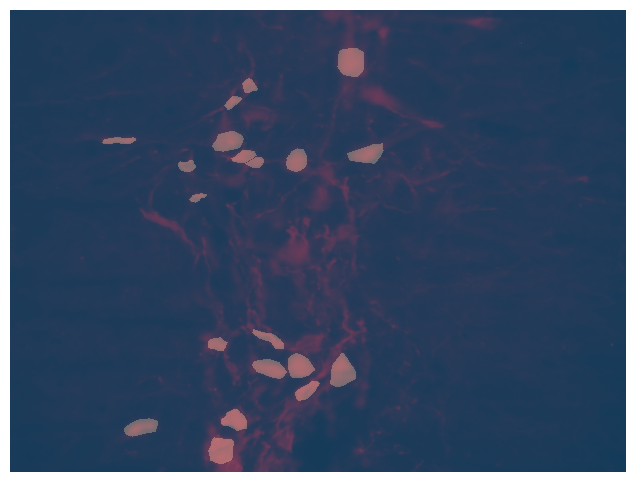

In [3]:
DEVICE = "cpu"
def label_func(p):
    return Path(str(p).replace('images', 'ground_truths/masks'))


trainval_path = dataset_path / "trainval" / "images" # edit dataset folder here: DATA_PATH_g --> green; DATA_PATH_y --> yellow; DATA_PATH_r --> red 

# read train/valid/test split dataframe
trainval_fnames = [fn for fn in trainval_path.iterdir()]

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
]

# splitter
splitter = RandomSplitter(valid_pct=VAL_PCT)

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    DATA_PATH, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device=DEVICE 
)

dls.show_batch(max_n=9, figsize=(8,6))

### Validation Dataloader

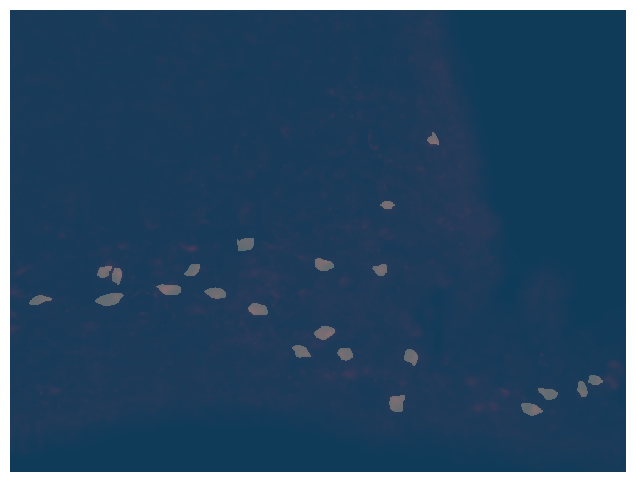

In [4]:
dls.valid.show_batch(max_n=9, figsize=(8,6))

### Test Dataloader

Number of test images: 46


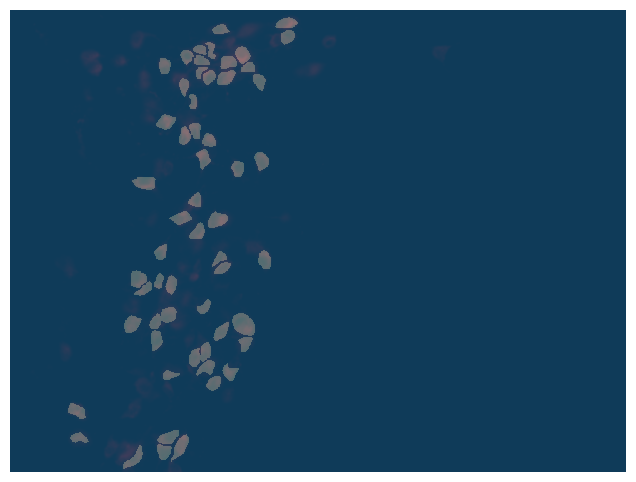

In [5]:
test_path = dataset_path / "test" / "images"
test_fnames = [fn for fn in test_path.iterdir()]

print(f"Number of test images: {len(test_fnames)}")
test_dl = dls.test_dl(test_fnames, with_labels=True)
test_dl.show_batch(figsize=(8,6))

## Learner

We need to use the same specification as the pre-trained model.

In [6]:
from fluocells.models import cResUnet, c_resunet


torch.set_printoptions(precision=10)

arch = "c-ResUnet"
# pretrained=True would load Morelli et al. 2021 weights. We add new pretrained weights after
cresunet = c_resunet(
    arch=arch, n_features_start=N_IN, n_out=N_OUT, pretrained=True # this would load Morelli et al. 2022
)
# cresunet = cResUnet(cfg.n_in, cfg.n_out)

learn = Learner(dls, model=cresunet, loss_func=LOSS_FUNC,
                metrics=[Dice(), JaccardCoeff(), foreground_acc],
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

loading pretrained Keras weights from /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/models/c-ResUnet_state_dict.pkl
Logs save path: /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/logs/red_98765
Model save path: /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/models/red_98765


cResUnet (Input shape: 1 x 3 x 1200 x 1600)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 1 x 1200 x 1600 
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     1 x 16 x 1200 x 160 
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     1 x 16 x 600 x 800  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                 

## Load model

We load one of the pre-trained models obtained from sample trainings.

In [7]:
print(f"Loading pesi da: {model_path}")

learn.load(model_path / 'model') # model.pth

Loading pesi da: /home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/models/red_98765


In [8]:
learn.eval()

cResUnet(
  (encoder): ModuleDict(
    (colorspace): Conv2d(3, 1, kernel_size=(1, 1), stride=(1, 1))
    (conv_block): ConvBlock(
      (conv_block): ModuleDict(
        (batchnorm2d_0): BatchNorm2d(1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_1): ELU(alpha=1.0)
        (conv2d_2): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batchnorm2d_3): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (activation_4): ELU(alpha=1.0)
        (conv2d_5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (residual_block1): ResidualBlock(
      (conv_path): ConvBlock(
        (conv_block): ModuleDict(
          (batchnorm2d_0): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (activation_1): ELU(alpha=1.0)
          (conv2d_2): Con

# Visual inspection

## Utils

Let's first define some utils to plot images, masks and predictions.

In [9]:
from skimage import measure
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

def _get_dataloader_batch(idx, dl=test_dl):
    for i, batch in enumerate(dl, start=1):
        if i==idx: break       
    return batch


def plot_heatmap(heatmap, ax):
    im = ax.imshow(heatmap, cmap='jet')  
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)

    # get colorbar to set params
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    return im


def plot_mask(mask: np.array, axis = None):
    """Plot mask with a different color per object and title."""
    labels, nobjs = measure.label(mask, return_num=True, connectivity=1)
    objs = measure.regionprops(labels)

    # create colormap: one color per object
    cmap = cm.get_cmap('tab20b', nobjs)

    # random shuffle to avoid similar colors to close-by objects
    np.random.shuffle(cmap.colors)

    # add black for background
    cmap = ListedColormap(np.insert(cmap.colors, 0, [0, 0, 0, 1], axis=0))

    # plot mask
    if axis is None:
        fig, axis = plt.subplots(1, 1, figsize=(8, 8))
    else: 
        fig = axis.figure
    axis.imshow(labels, cmap=cmap, vmin=0, vmax=nobjs)
    for obj in objs:
        plt.text(obj.bbox[1], obj.bbox[0], obj.label,
                 fontdict=dict(color='white', size=7),
                 bbox=dict(fill=False, linewidth=0)
                 )

    return fig, axis, cmap

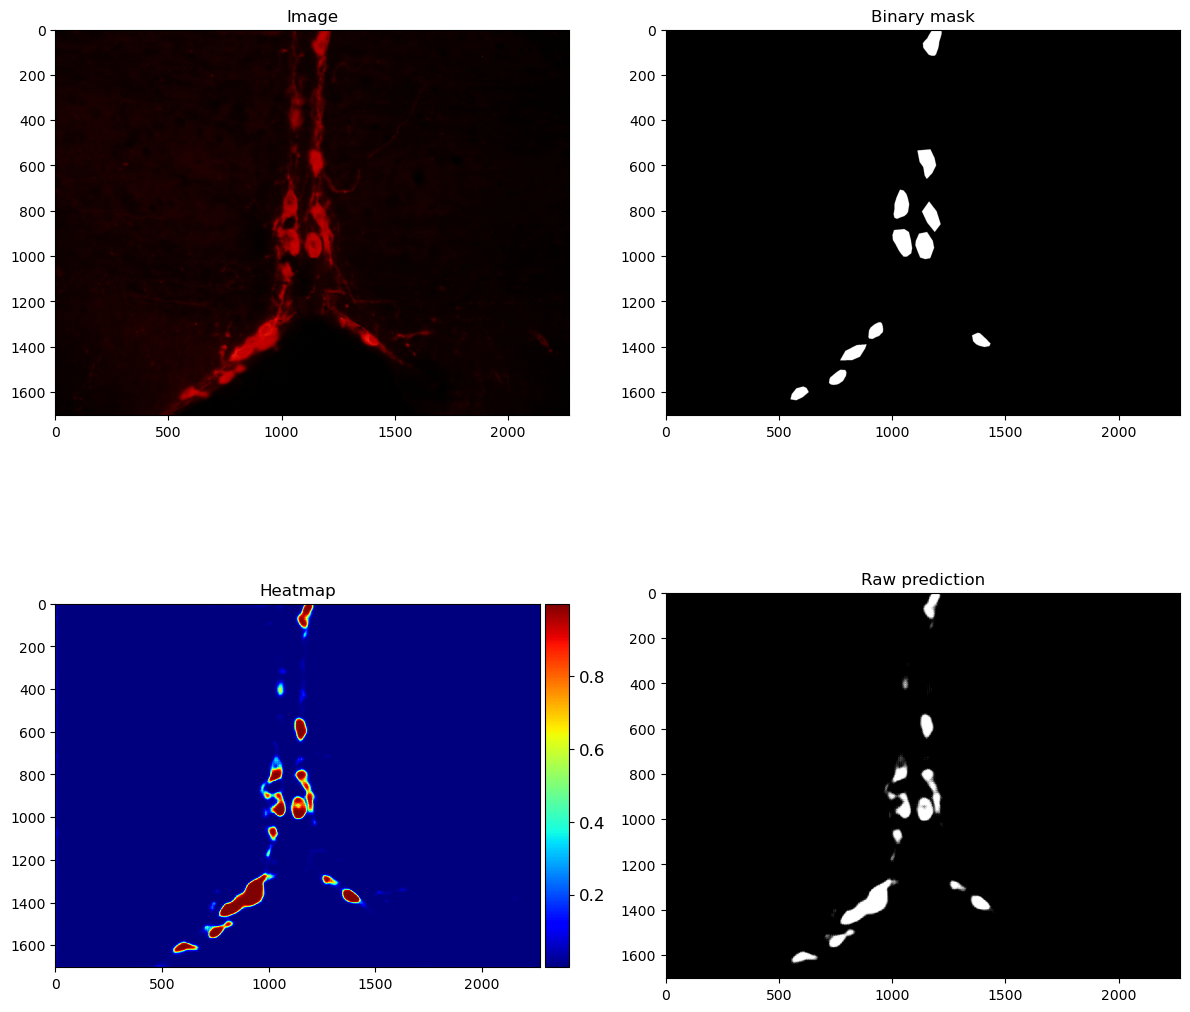

In [10]:
# validation dataloader
img, mask = _get_dataloader_batch(17, dls.valid)
heatmap = learn.model(img)

# convert to matplotlib format
C=1
img = img.squeeze().permute(1,2,0).to("cpu")
mask = mask.squeeze().to("cpu")

heatmap_plot = heatmap.squeeze().permute(1,2,0)[:,:,C].detach().to("cpu")
pred_mask = heatmap.squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8).to("cpu")

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()
axes[0].imshow(img)
axes[0].set_title('Image')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary mask')
plot_heatmap(heatmap_plot, axes[2])
axes[2].set_title('Heatmap')
axes[3].imshow(pred_mask, cmap='gray')
axes[3].set_title('Raw prediction')
plt.tight_layout()
plt.show()

## Post-processing



/home/luca/miniconda3/envs/fluocells/lib/python3.9/site-packages/skimage/_shared/utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/home/luca/workspace/luca/PycharmProjects/fluocells-scientific-data/fluocells/utils/data.py:519: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(


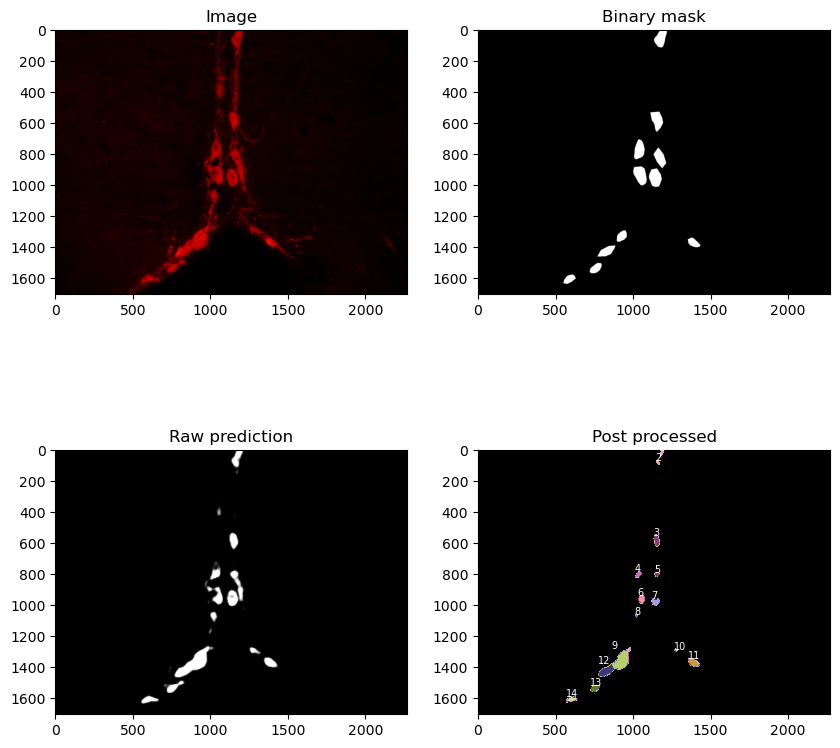

In [11]:
from fluocells.utils.data import post_process


threshold = 0.9
smooth_disk=3
max_hole = 50
min_size = 250
max_filt = 20
fp = 40

thresh_image = np.squeeze((heatmap_plot.numpy() > threshold).astype('uint8'))
post_proc_mask = post_process(thresh_image, smooth_disk, max_hole, min_size, max_filt, fp)

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

axes[0].imshow(img)
axes[0].set_title('Image')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Binary mask')
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title('Raw prediction')
plot_mask(post_proc_mask, axes[3])
axes[3].set_title('Post processed')
plt.show()

<div class="alert alert-block alert-info">

The model is able to differentiate most of cells from the background. However, the contour definition is not very sharp.
This causes the risk of close objects being joined, and in general brings to inaccurate shape reconstruction.
    
Such observations suggest dedicated care should be devoted to training strategies aimed to mitigate these issues.
    
</div>

# Evaluation

Here we demonstrate the suggested metrics for segmentation and detection tasks, namely **IoU** and **proximity** objects matching.

In the case of **IoU**, this associates true and predicted objects that overlap by more than a given `IOU_THRESH` cutoff. In this way, we test model's ability to precisely reconstruct neurons shape.

Regarding **proximity**, this time we associate objects whose centers are closer than `PROX_THRESH`. The latter criterion is looser, as it only requires the reconstructed object to be sufficiently close to the actual one.
For this reason, this metric can be representative of detection performance in applications where sharp contours are not needed.

In [12]:
# Usage
from skimage import measure
from fluocells.utils.metrics import iou_metrics


IOU_THRESH = 0.3

mask_label = measure.label(mask)
pred_mask_label = measure.label(post_proc_mask)

TP, FP, FN = iou_metrics(mask_label, pred_mask_label, IOU_THRESH)
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

True Positives: 6, False Positives: 8, False Negatives: 5


In [13]:
# Usage
from skimage import measure
from fluocells.utils.metrics import proximity_metrics

PROX_THRESH = 65

mask_label = measure.label(mask)
pred_mask_label = measure.label(post_proc_mask)

TP, FP, FN = proximity_metrics(mask_label, pred_mask_label, PROX_THRESH)
print(f"True Positives: {TP}, False Positives: {FP}, False Negatives: {FN}")

True Positives: 11, False Positives: 2, False Negatives: 0


<div class="alert alert-block alert-info">

As expected, the proximity criterion produces better metrics compared to IoU object matching. 
In fact, the model is able to detect the neurons correctly, however it finds hard times trying to reproduce their shape (cf. for instance objects 1 to 10 in the *post processed* mask).
</div>